In [33]:
import polars as pl
import numpy as np
from datetime import datetime
from polars import DataFrame, LazyFrame, Series, Expr

In [34]:
pl.__version__

'0.15.8'

In [35]:
np.__version__

'1.24.0'

In [36]:
# concat

df1: DataFrame = pl.DataFrame({
    'a' : np.arange(0, 10, 4),
    'b' : np.random.random(3),
})

df2: DataFrame = pl.DataFrame({
    'a' : np.random.randint(1, 10, size=3),
    'b' : np.random.rand(3)
})

df3: DataFrame = pl.DataFrame({
    'a' : np.random.randint(1, 10, size=3),
    'b' : np.random.rand(3)
})

In [37]:
def generate_sample_dataset(n: int=10) -> pl.DataFrame:
    df: pl.DataFrame = pl.DataFrame({
        'a' : np.random.randint(0, 10, size=n),
        'b' : np.random.random(size=n),
        'c' : np.random.choice(['red', 'green', 'blue', 'cyan', 'magenta', 'yellow'], size=n),
        'd' : np.random.choice(np.arange('2022-12-29', '2023-12-01', dtype='datetime64[D]').astype(str), size=n),
        'e' : np.random.choice(pl.date_range(datetime(2022,12,29), datetime(2023,12,1), interval='1mo', closed='right'), size=n),
    })
    return df.with_column(pl.col('d').str.strptime(pl.Date, fmt='%Y-%m-%d').alias('date')).drop('d').rename({'date' : 'd'})

In [38]:
(
    generate_sample_dataset()
    .lazy()
    .select(
        [
            pl.all().suffix('_suffix'),
            pl.min('b').alias('min'),
            pl.max('b').alias('max'),
            pl.median('b').alias('median'),
            pl.mean('b').alias('mean'),
            pl.std('b').alias('sd'),
            pl.var('b').alias('variance'),
            pl.count('b').alias('count'),
        ]
    )
    .sort(by='a_suffix')
    .collect()
    .sample(5)
    .slice(0, 2)
)

shape: (2, 12)
┌──────────┬──────────┬──────────┬──────────────┬─────┬────────┬──────────┬──────────┬───────┐
│ a_suffix ┆ b_suffix ┆ c_suffix ┆ e_suffix     ┆ ... ┆ mean   ┆ sd       ┆ variance ┆ count │
│ ---      ┆ ---      ┆ ---      ┆ ---          ┆     ┆ ---    ┆ ---      ┆ ---      ┆ ---   │
│ i64      ┆ f64      ┆ str      ┆ datetime[μs] ┆     ┆ f64    ┆ f64      ┆ f64      ┆ u32   │
╞══════════╪══════════╪══════════╪══════════════╪═════╪════════╪══════════╪══════════╪═══════╡
│ 0        ┆ 0.392161 ┆ cyan     ┆ 2023-11-28   ┆ ... ┆ 0.5072 ┆ 0.323814 ┆ 0.104856 ┆ 10    │
│          ┆          ┆          ┆ 00:00:00     ┆     ┆        ┆          ┆          ┆       │
├╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┤
│ 0        ┆ 0.288961 ┆ cyan     ┆ 2023-11-28   ┆ ... ┆ 0.5072 ┆ 0.323814 ┆ 0.104856 ┆ 10    │
│          ┆          ┆          ┆ 00:00:00     ┆     ┆        ┆          ┆          ┆       │
└──────────┴──────────┴──────────┴──────────────┴─────┴────────┴──────────┴──────────┴───────┘

In [39]:
from typing import List
dfs: List[DataFrame] = [df1, df2, df3]

concat_df: DataFrame = pl.concat(dfs, rechunk=True, how='vertical')
concat_df.shape

(9, 2)

In [40]:
concat_df

shape: (9, 2)
┌─────┬──────────┐
│ a   ┆ b        │
│ --- ┆ ---      │
│ i64 ┆ f64      │
╞═════╪══════════╡
│ 0   ┆ 0.511937 │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ 4   ┆ 0.551283 │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ 8   ┆ 0.103149 │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ 4   ┆ 0.044239 │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ ... ┆ ...      │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ 1   ┆ 0.696992 │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ 9   ┆ 0.505269 │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ 6   ┆ 0.108279 │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ 1   ┆ 0.818592 │
└─────┴──────────┘

In [41]:
concat_df._compare_to_other_df(df1.vstack(df2).vstack(df3), 'eq')

shape: (9, 2)
┌──────┬──────┐
│ a    ┆ b    │
│ ---  ┆ ---  │
│ bool ┆ bool │
╞══════╪══════╡
│ true ┆ true │
├╌╌╌╌╌╌┼╌╌╌╌╌╌┤
│ true ┆ true │
├╌╌╌╌╌╌┼╌╌╌╌╌╌┤
│ true ┆ true │
├╌╌╌╌╌╌┼╌╌╌╌╌╌┤
│ true ┆ true │
├╌╌╌╌╌╌┼╌╌╌╌╌╌┤
│ ...  ┆ ...  │
├╌╌╌╌╌╌┼╌╌╌╌╌╌┤
│ true ┆ true │
├╌╌╌╌╌╌┼╌╌╌╌╌╌┤
│ true ┆ true │
├╌╌╌╌╌╌┼╌╌╌╌╌╌┤
│ true ┆ true │
├╌╌╌╌╌╌┼╌╌╌╌╌╌┤
│ true ┆ true │
└──────┴──────┘

In [42]:
concat_df.head(3)

shape: (3, 2)
┌─────┬──────────┐
│ a   ┆ b        │
│ --- ┆ ---      │
│ i64 ┆ f64      │
╞═════╪══════════╡
│ 0   ┆ 0.511937 │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ 4   ┆ 0.551283 │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ 8   ┆ 0.103149 │
└─────┴──────────┘

In [43]:
concat_df.groupby('a').agg(
    [
        pl.all().suffix('_cum'),
        pl.col('b').sum().alias('sum'),
        pl.cumsum('b').alias('cumsum'),
        pl.mean('b').alias('mean')
    ]
).sort('a')

shape: (7, 5)
┌─────┬──────────────────────┬──────────┬──────────────────────┬──────────┐
│ a   ┆ b_cum                ┆ sum      ┆ cumsum               ┆ mean     │
│ --- ┆ ---                  ┆ ---      ┆ ---                  ┆ ---      │
│ i64 ┆ list[f64]            ┆ f64      ┆ list[f64]            ┆ f64      │
╞═════╪══════════════════════╪══════════╪══════════════════════╪══════════╡
│ 0   ┆ [0.511937]           ┆ 0.511937 ┆ [0.511937]           ┆ 0.511937 │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ 1   ┆ [0.696992, 0.818592] ┆ 1.515584 ┆ [0.696992, 1.515584] ┆ 0.757792 │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ 4   ┆ [0.551283, 0.044239] ┆ 0.595522 ┆ [0.551283, 0.595522] ┆ 0.297761 │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ 6   ┆ [0.108279]           ┆ 0.108279 ┆ [0.108279]           ┆ 0.108279 │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ 7   ┆ [0.990031]           ┆ 0.990031 ┆ [0.990031]           ┆ 0.990031 │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ 8   ┆ [0.103149]           ┆ 0.103149 ┆ [0.103149]           ┆ 0.103149 │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ 9   ┆ [0.505269]           ┆ 0.505269 ┆ [0.505269]           ┆ 0.505269 │
└─────┴──────────────────────┴──────────┴──────────────────────┴──────────┘

In [44]:
(
    generate_sample_dataset()
    .lazy()
    .select(
        [
            pl.all().suffix('_suffix'),
            pl.col('a').cumsum().over('c').alias('sum_over'),
        ]
    )
    .collect()
    .head(3)
)

shape: (3, 6)
┌──────────┬──────────┬──────────┬─────────────────────┬────────────┬──────────┐
│ a_suffix ┆ b_suffix ┆ c_suffix ┆ e_suffix            ┆ d_suffix   ┆ sum_over │
│ ---      ┆ ---      ┆ ---      ┆ ---                 ┆ ---        ┆ ---      │
│ i64      ┆ f64      ┆ str      ┆ datetime[μs]        ┆ date       ┆ i64      │
╞══════════╪══════════╪══════════╪═════════════════════╪════════════╪══════════╡
│ 1        ┆ 0.979985 ┆ blue     ┆ 2023-02-28 00:00:00 ┆ 2023-05-07 ┆ 1        │
├╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ 1        ┆ 0.923798 ┆ cyan     ┆ 2023-08-28 00:00:00 ┆ 2023-09-29 ┆ 1        │
├╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ 7        ┆ 0.788483 ┆ red      ┆ 2023-07-28 00:00:00 ┆ 2023-09-28 ┆ 7        │
└──────────┴──────────┴──────────┴─────────────────────┴────────────┴──────────┘

In [45]:
(
    generate_sample_dataset()
    .with_column((pl.col('a') * 2 + 1).alias('e'))
    .select(
        [
            pl.cov('a', 'e').alias('cov(a, e)'),
            pl.pearson_corr('a', 'e').alias('person_corr(a, e)'),
        ]
    )
)

shape: (1, 2)
┌───────────┬───────────────────┐
│ cov(a, e) ┆ person_corr(a, e) │
│ ---       ┆ ---               │
│ f64       ┆ f64               │
╞═══════════╪═══════════════════╡
│ 22.333333 ┆ 1.0               │
└───────────┴───────────────────┘

In [46]:
import pathlib
df: pl.DataFrame = pl.concat(
    [
        pl.read_csv(file) for file in pathlib.Path('data/test').rglob('out*.csv')
    ]
)

df.head(3)

shape: (3, 4)
┌─────┬──────────┬──────┬────────────┐
│ a   ┆ b        ┆ c    ┆ d          │
│ --- ┆ ---      ┆ ---  ┆ ---        │
│ i64 ┆ f64      ┆ str  ┆ str        │
╞═════╪══════════╪══════╪════════════╡
│ 1   ┆ 0.267338 ┆ red  ┆ 2023-04-16 │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 1   ┆ 0.891371 ┆ red  ┆ 2023-01-20 │
├╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 9   ┆ 0.121716 ┆ blue ┆ 2023-11-18 │
└─────┴──────────┴──────┴────────────┘

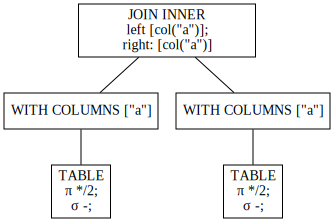

In [47]:
# SQL joins

lf1 = pl.DataFrame({"a": ["foo", "bar", "ham"], "b": [1, 2, 3]}).lazy()
lf2 = pl.DataFrame({"a": ["foo", "spam", "eggs"], "c": [3, 2, 2]}).lazy()

lf1 = lf1.with_column(pl.col("a").cast(pl.Categorical))
lf2 = lf2.with_column(pl.col("a").cast(pl.Categorical))

lf1.join(lf2, on="a", how="inner").show_graph()

## NumPy interop (universal functions or vectorized functions)

- np.ufuncs
  - .nim
  - .nout
  - .nargs
  - .ntypes
  - .identity
  - .signature
  - .reduce
  - .accumulate
  - .reduceat
  - .outer
  - .at
- math operations
  - add
  - subtract
  - multiply
  - matmul
  - divide
  - logaddexp
  - logaddexp2
  - true_divide
  - floor_divide
  - negative
  - positive
  - power
  - float_power
  - remainder
  - mod
  - fmod
  - divmod
  - absolute
  - fabs
  - rint
  - sign
  - heaviside
  - conj
  - conjugate
  - exp
  - exp2
  - log
  - log2
  - log10
  - expml
  - log1p
  - sqrt
  - squre
  - cbrt
  - reciprocal
  - gcd
  - lcm
- Trigonometric functions
  - ...
- Bit-twiddling functions
  - ...
- Comparison functions
  - ...
- Floating functions
  - ...

In [48]:
# nump ufuncs basics

x = np.arange(9).reshape(3,3)
x

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [49]:
# all ufuncs have 4 methods
np.add.reduce(x, 1)

array([ 3, 12, 21])

In [50]:
np.add.reduce(x, 0)

array([ 9, 12, 15])

In [51]:
np.add.reduce(x, (0, 1))

36

In [52]:
x.dtype

dtype('int64')

In [53]:
np.multiply.reduce(x, dtype=float)

array([ 0., 28., 80.])

In [54]:
y = np.zeros(3, dtype=np.int8)
y

array([0, 0, 0], dtype=int8)

In [55]:
np.multiply.reduce(x, dtype=float, out=y)

array([ 0, 28, 80], dtype=int8)

In [56]:
np.typecodes

{'Character': 'c',
 'Integer': 'bhilqp',
 'UnsignedInteger': 'BHILQP',
 'Float': 'efdg',
 'Complex': 'FDG',
 'AllInteger': 'bBhHiIlLqQpP',
 'AllFloat': 'efdgFDG',
 'Datetime': 'Mm',
 'All': '?bhilqpBHILQPefdgFDGSUVOMm'}

In [57]:
print('X ' + ' '.join(np.typecodes['All']))

X ? b h i l q p B H I L Q P e f d g F D G S U V O M m


In [58]:
for row in np.typecodes['All']:
    print(row, end='')
    for col in np.typecodes['All']:
        print({False:' -', True: ' Y'}[np.can_cast(row, col)], end='')
    print()

? Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y - Y
b - Y Y Y Y Y Y - - - - - - Y Y Y Y Y Y Y Y Y Y Y - Y
h - - Y Y Y Y Y - - - - - - - Y Y Y Y Y Y Y Y Y Y - Y
i - - - Y Y Y Y - - - - - - - - Y Y - Y Y Y Y Y Y - Y
l - - - - Y Y Y - - - - - - - - Y Y - Y Y Y Y Y Y - Y
q - - - - Y Y Y - - - - - - - - Y Y - Y Y Y Y Y Y - Y
p - - - - Y Y Y - - - - - - - - Y Y - Y Y Y Y Y Y - Y
B - - Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y - Y
H - - - Y Y Y Y - Y Y Y Y Y - Y Y Y Y Y Y Y Y Y Y - Y
I - - - - Y Y Y - - Y Y Y Y - - Y Y - Y Y Y Y Y Y - Y
L - - - - - - - - - - Y Y Y - - Y Y - Y Y Y Y Y Y - -
Q - - - - - - - - - - Y Y Y - - Y Y - Y Y Y Y Y Y - -
P - - - - - - - - - - Y Y Y - - Y Y - Y Y Y Y Y Y - -
e - - - - - - - - - - - - - Y Y Y Y Y Y Y Y Y Y Y - -
f - - - - - - - - - - - - - - Y Y Y Y Y Y Y Y Y Y - -
d - - - - - - - - - - - - - - - Y Y - Y Y Y Y Y Y - -
g - - - - - - - - - - - - - - - - Y - - Y Y Y Y Y - -
F - - - - - - - - - - - - - - - - - Y Y Y Y Y Y Y - -
D - - - - - - - - - - - - - 

In [59]:
def save_data_to_csv(n: int=10) -> None:
    import os
    for f in pathlib.Path('data/test').rglob('output*.csv'):
        os.remove(f.absolute())

    for i in range(n):
        df: pl.DataFrame = generate_sample_dataset(np.random.randint(5, 10))
        match i:
            case i if i % 3 == 0:
                df.write_csv(f"data/test/3/output{i:0>3}.csv")
            case i if i % 5 == 0:
                df.write_csv(f"data/test/5/output{i:0>3}.csv")
            case i if i % 7 == 0:
                df.write_csv(f"data/test/7/output{i:0>3}.csv")
            case _:
                df.write_csv(f"data/test/output{i:0>3}.csv")

In [60]:
save_data_to_csv(n=50)

In [61]:
agg_df: pl.DataFrame = (
    pl.concat([pl.scan_csv(f.absolute()) for f in pathlib.Path('data/test').rglob('output*.csv')])
    .groupby('c')
    .agg(
        [
            pl.col('b').mean().alias('mean'),
            pl.col('a').mode().alias('mode'),
            pl.col('d').n_unique().alias('n_unique'),
            # pl.col('b').rank().over('c').alias('rank'),
        ]
    )
    .collect(streaming=True)
)

In [62]:
agg_df

shape: (6, 4)
┌─────────┬──────────┬───────────┬──────────┐
│ c       ┆ mean     ┆ mode      ┆ n_unique │
│ ---     ┆ ---      ┆ ---       ┆ ---      │
│ str     ┆ f64      ┆ list[i64] ┆ u32      │
╞═════════╪══════════╪═══════════╪══════════╡
│ cyan    ┆ 0.464266 ┆ [9, 3]    ┆ 51       │
├╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ green   ┆ 0.451753 ┆ [8]       ┆ 61       │
├╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ yellow  ┆ 0.525558 ┆ [1]       ┆ 46       │
├╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ magenta ┆ 0.514129 ┆ [1]       ┆ 54       │
├╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ red     ┆ 0.464342 ┆ [8]       ┆ 51       │
├╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ blue    ┆ 0.511454 ┆ [8]       ┆ 58       │
└─────────┴──────────┴───────────┴──────────┘